<a href="https://colab.research.google.com/github/tjessica13/MLH-GHW-August2024/blob/main/Vision_Transformer_MLH_GHW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with your First Vision Transformer

Major League Hacking Global Hack Week: AI/ML August 2024

**References: Code from Stephen from MLH**

In [ ]:
# install torch, model, and matplot
!pip install torch torchvision timm matplotlib

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import timm
from datetime import datetime
import matplotlib.pyplot as plt

# CIFAR 10 Dataset

**What is CIFAR10 ?**

https://en.wikipedia.org/wiki/CIFAR-10

10 Classes: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks



In [ ]:
# transform function for the images to be used with the model
transform = transforms.Compose([
    transforms.Resize((224, 224)), #resize the image for the model
    transforms.ToTensor(), # convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalize
])

### With Data Augmentation

In [ ]:
# data augmentation applied to the training set
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# validation set does not need data augmentation
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# getting the CIFAR10 training and validation sets and applying the transform functions
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

Files already downloaded and verified
Files already downloaded and verified


### Without Data Augmentation

In [ ]:
# get the CIFAR 10 dataset without data augmentation
# https://pytorch.org/vision/0.18/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# training set is 80 percent of the dataset
train_size = int(0.8 * len(dataset))
# validation set is the rest of the dataset (20 percent not in training)
val_size = len(dataset) - train_size
# split the dataset into train and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

100%|██████████| 170498071/170498071 [00:03<00:00, 49283629.45it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


### Setting train and validation loaders

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# ViT Model

In [ ]:
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        # inherit properties of ViTModel
        super(ViTModel, self).__init__()
        # timm model vit_base_patch16_244 - 16 patches 224 pixels
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True)
        # linear layer connecting model
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)

    # feed forward function to update state of model
    def forward(self, x):
        return self.model(x)

**Hyperparameters**

* batch size
*   Learning Rate
* number of epochs - training time



In [ ]:
BATCH_SIZE = 64
LR = 1e-4
N_EPOCHS = 1
NUM_CLASSES = 10

In [ ]:
# Initialize model, loss function, and optimizer

# Google colab using T4 GPU should not take as long as using CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTModel(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()

# tweak parameters of model according to learning rate
optimizer = optim.Adam(model.parameters(), lr=LR)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Training and validation loop
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(N_EPOCHS):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f'Epoch [{epoch+1}/{N_EPOCHS}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Loss: {val_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]*100:.2f}%')

Epoch [1/1], Train Loss: 0.1983, Validation Loss: 0.1420, Validation Accuracy: 95.47%


**Training Time:**
With one Epoch and batch size of 64, the training time was around 23 minutes.

In [ ]:
# Save the model
torch.save(model.state_dict(), 'vit_cifar10.pth')

# Visualize Model Performance

These would show the performance with line graphs when we have more than one epoch.

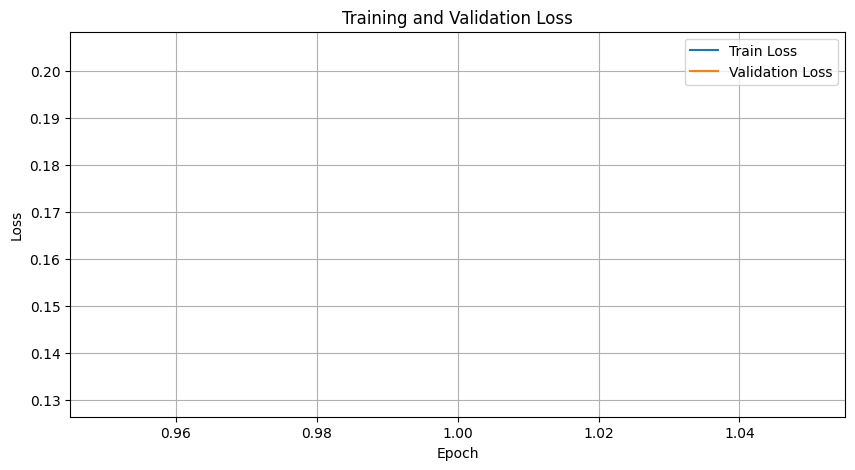

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, N_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, N_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

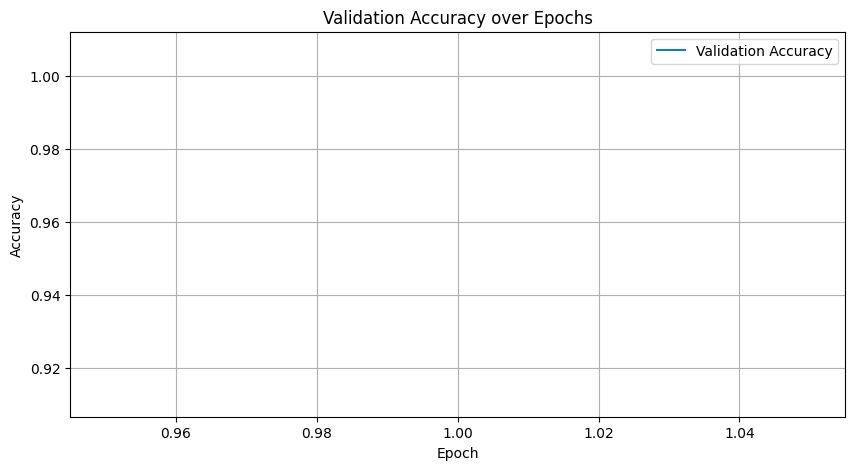

In [ ]:
# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, N_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation Metrics


1.   Precision
2.   Recall
3.   Accuracy

Confusion Matrix

# Extra Challenges after Workshop
* Get a higher score than 95% on CIFAR10
* data augmentation for training set





